# Rectified Flow

Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow, Liu et al., 2022. [[arXiv:2209.03003](https://arxiv.org/abs/2209.03003)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

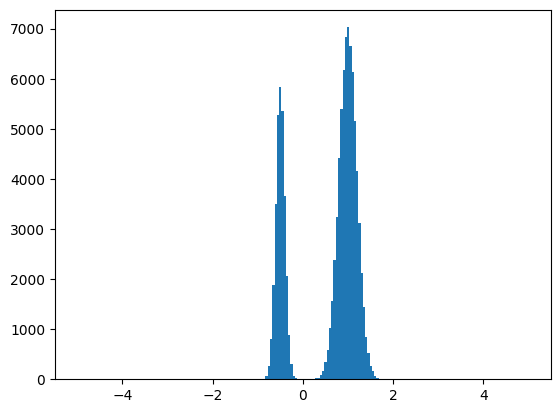

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and rectified flow framework.

In [2]:
from flowmodels import RectifiedFlow
from utils import Backbone


COND = False
aux = 1 if not COND else 2
model = RectifiedFlow(Backbone(aux=aux))
model

RectifiedFlow(
  (velocity_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Rectified FLow

Train the ODE model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

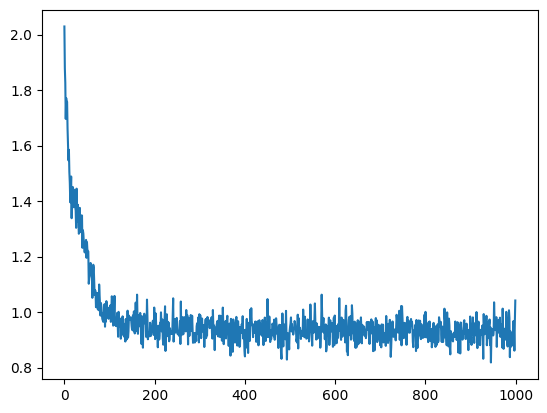

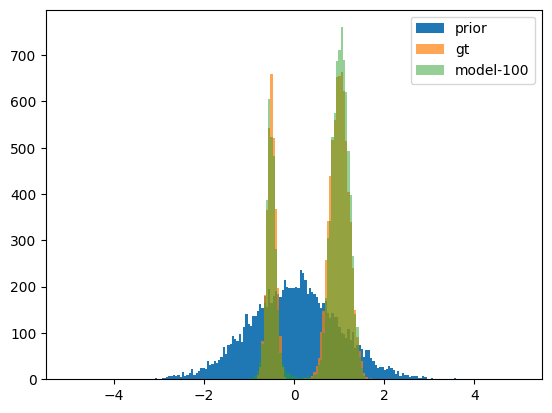

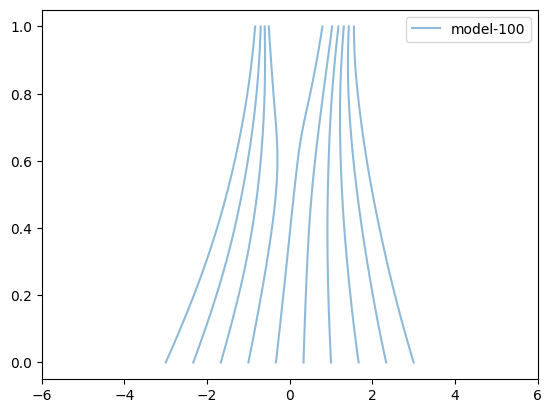

In [3]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indicies = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(
            sample=X[indicies],
            label=Y[indicies] if COND else None,
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=COND, steps=[100])

## 4. Inversion Methods

Introduce some inversion methods for rectified flows.

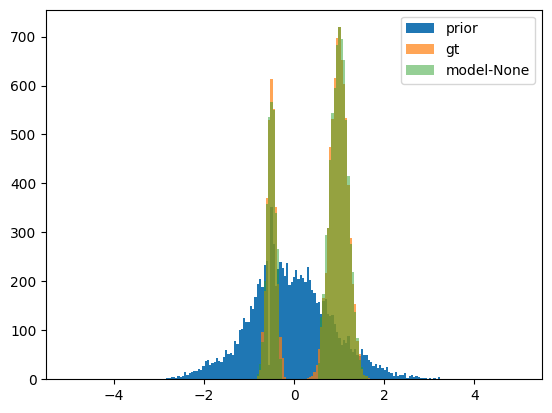

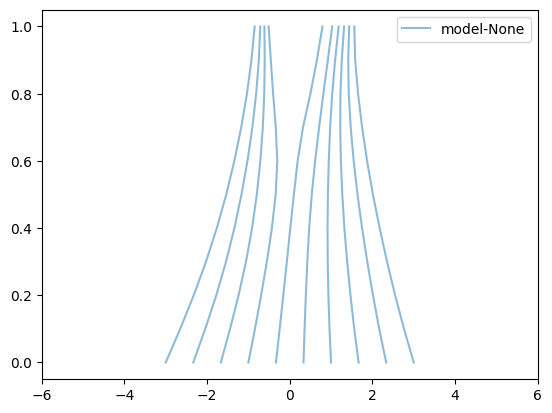

In [4]:
# RF-Solver
# , Taming Rectified Flow for Inversion and Editing, Wang et al., 2024.
from flowmodels import RFSolver, RFInversion

indices = torch.randperm(len(X))[:10000]
prior, _ = RFInversion().solve(model, X, Y if COND else None)
model.solver = RFSolver()
vis(model, prior=prior[indices], conditional=COND, steps=[None])

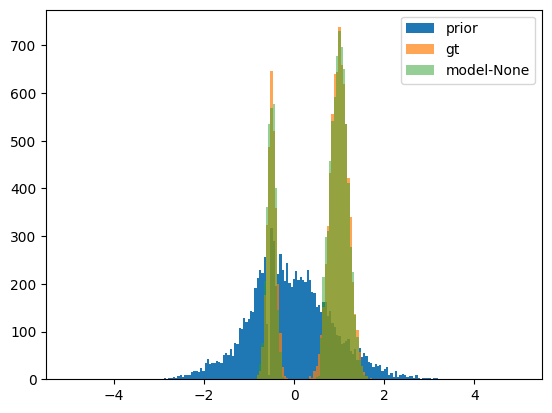

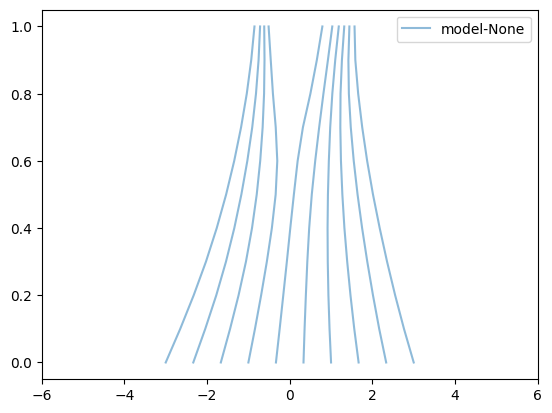

In [5]:
# FireFlow
# , Fast Inversion of Rectified Flow for Image Semantic Editing, Deng et al., 2024.
from flowmodels import FireFlowSolver, FireFlowInversion
from flowmodels.utils import VelocityInverter

prior, _ = FireFlowInversion().solve(model, X, Y if COND else None)
model.solver = FireFlowSolver()
vis(model, prior=prior[indices], conditional=COND, steps=[None])

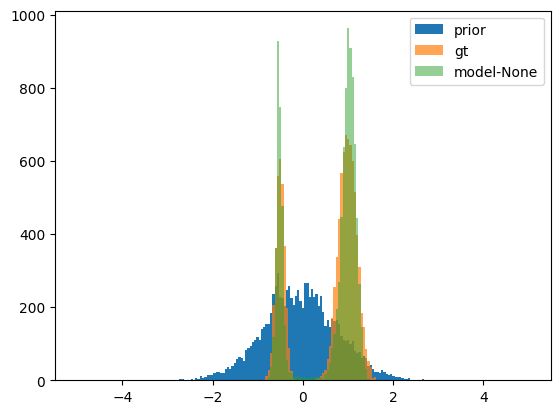

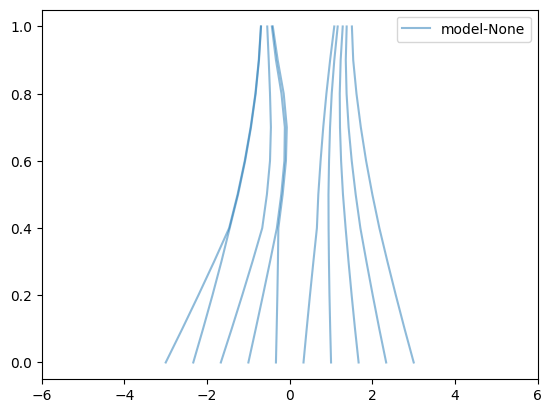

In [6]:
# Controlled ODE
# , Semantic Image Inversion And Editing Using Rectified Stochastic Differential Equations
# , Rout et al., 2024.[arXiv:2410.10792]
from flowmodels import ControlledODESolver, ControlledODEInversion

prior, _ = ControlledODEInversion().solve(model, X, Y if COND else None)
model.solver = ControlledODESolver()
model.solver.reference = X[indices]
vis(model, prior=prior[indices], conditional=COND, steps=[None])

### Reflow

Reflow the model to straighten the trajectory.

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

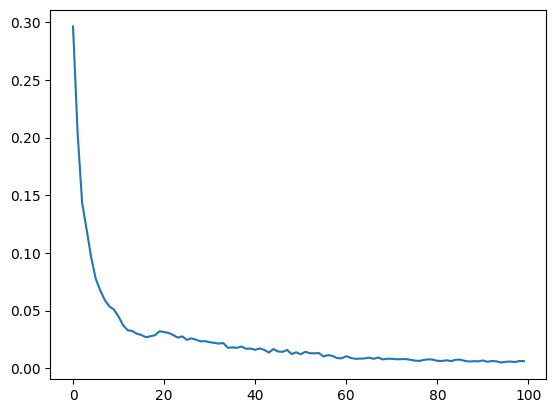

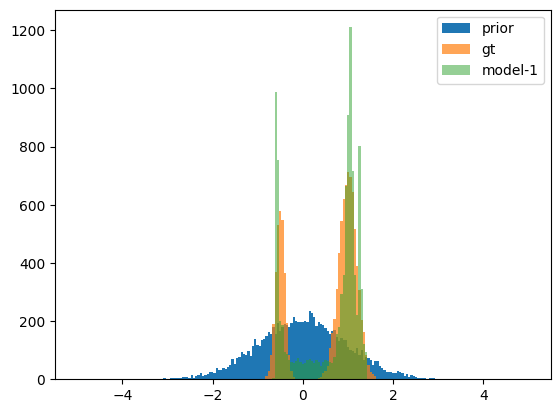

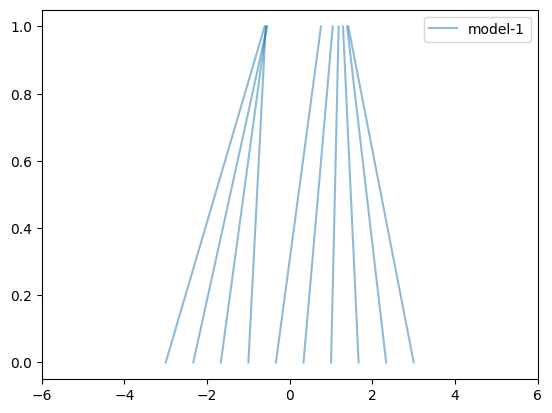

In [7]:
from flowmodels import VanillaEulerSolver

# Reflow
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 100
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])

optim = torch.optim.Adam(model.parameters(), LR)
model.solver = VanillaEulerSolver()
losses = model.reflow(
    optim,
    prior,
    training_steps=TRAIN_STEPS,
    batch_size=BATCH_SIZE,
    sample=SAMPLE_STEPS,
    label=Y[torch.randperm(len(Y))[:n]] if COND else None,
    verbose=lambda x: tqdm(x, leave=False),
)

plt.plot(losses)
vis(model, conditional=COND, steps=[1])

### Distillation

Distill the model for single-step generation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

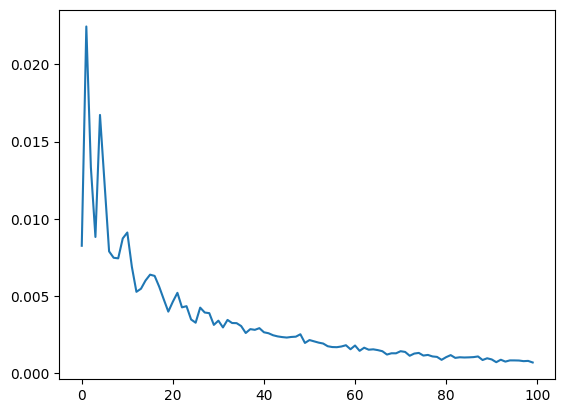

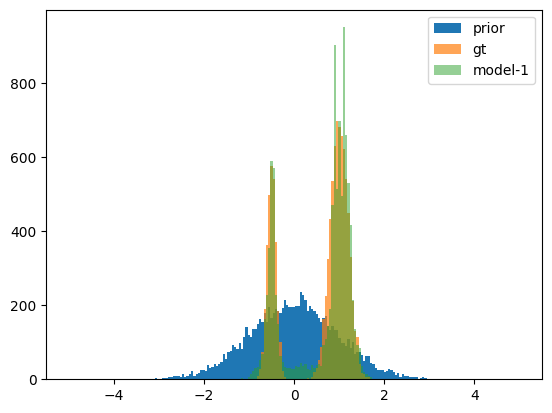

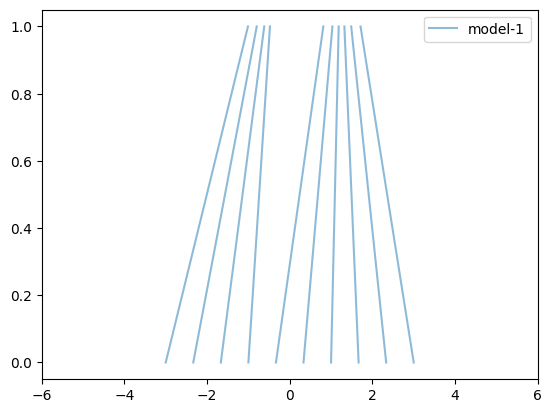

In [8]:
# Distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 100
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])

optim = torch.optim.Adam(model.parameters(), LR)
losses = model.distillation(
    optim,
    prior,
    training_steps=TRAIN_STEPS,
    batch_size=BATCH_SIZE,
    sample=SAMPLE_STEPS,
    label=Y[torch.randperm(len(Y))[:n]] if COND else None,
    verbose=lambda x: tqdm(x, leave=False),
)

plt.plot(losses)
vis(model, conditional=COND, steps=[1])